In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(0)

%matplotlib inline

In [2]:
import Utils as utils
training_labels,training_images = utils.get_train_data(False,size=1500)
print(len(training_labels),len(training_images))

1500 1500


In [3]:
training_labelsL = training_labels[:,:,:2].reshape(len(training_labels),-1)
print(len(training_labelsL),training_labels.shape,training_labelsL.shape,training_images.shape,training_labelsL[0])

1500 (1500, 21, 3) (1500, 42) (1500, 224, 224, 3) [148.25009003 162.60378689 146.54701233 163.58191461 145.01880646
 164.55899794 142.35836639 170.75488281 143.0549057  174.89945475
 146.82319489 163.17435981 146.31686554 171.81452908 146.63907318
 174.34137641 147.05333099 177.3572781  149.30876312 163.82645128
 148.43421173 171.48849284 148.11200409 174.5858941  147.83878021
 177.3062934  150.8737442  164.96759711 150.59757233 171.08093804
 150.13727875 173.11871202 149.30876312 175.40102268 152.25461426
 166.27178006 152.20858917 171.81452908 151.5148056  173.38404134
 150.91977997 174.66741265]


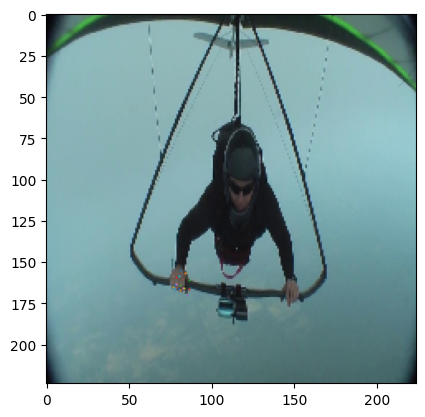

In [4]:
imgIndex = 1
plt.imshow(training_images[imgIndex])
for i in training_labels[imgIndex]:
    plt.plot(i[0],i[1],".",markersize=1)

In [97]:
def model_load() :
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(training_images.shape[1],training_images.shape[2],3),#( 540, 960, 3),
    )

    base_model.trainable = True
    for i in range(len(base_model.layers)- 20) : 
    # for i in range(0,127) : 
        base_model.layers[i].trainable = False

    inputLayer = layers.Input(shape=(training_images.shape[1],training_images.shape[2],3))
    x = preprocess_input(inputLayer)
    # x = layers.Conv2D(3, (3,3), padding = 'same', activation = 'linear',
    #                       kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))(x)
    # x = layers.MaxPool2D(1,strides=(2,2))(x)
    # x = layers.Conv2D(3, (3,3), padding = 'same')(x)
    
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x) 
    # x = layers.MaxPool2D(pool_size=(2, 2))(x) 
    # x = layers.Flatten()(x) 
    # x = layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(x) 
    # x = layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(x) 
    # x = layers.Dropout(0.3)(x)
    # x = layers.SeparableConv2D(
    #     training_labelsL.shape[1], kernel_size=5, strides=1, activation="relu"
    # )(x)
    # prediction_layer = layers.SeparableConv2D(
    #     training_labelsL.shape[1], kernel_size=3, strides=1, activation="relu"
    # )(x)
    # x = layers.Dense(1500)(x)
    # x = layers.Dense(1000)(x)
    # x = layers.Dense(500)(x)
    # x = layers.Dense(250)(x)
    # x = layers.Dense(100)(x)
    # x = layers.Dense(70)(x)

    prediction_layer = layers.Dense(training_labelsL.shape[1])(x)


    return tf.keras.Model(inputs=inputLayer,outputs=prediction_layer)

In [106]:
model = model_load()

In [107]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
      loss=tf.keras.losses.MeanSquaredError()
    ,
      metrics= [ 
          tf.keras.metrics.RootMeanSquaredError(name='rmse'),
          'acc'
      ]
)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_12  (None, 1280)             0         
  (GlobalAveragePooling2D)                                

In [108]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="rmse", patience=50, restore_best_weights=True
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='rmse', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

In [109]:
with tf.device("/GPU:0"):
    model_history = model.fit(training_images, training_labelsL,
                              epochs=500, 
                              callbacks = [early_stopping, rlp],
                               workers=4, use_multiprocessing=True,batch_size=16,validation_split=0.2
                             )

Epoch 1/500
75/75 [==============================] - 7s 61ms/step - loss: 10007.6787 - rmse: 100.0384 - acc: 0.0117 - val_loss: 11747.0234 - val_rmse: 108.3837 - val_acc: 0.0233 - lr: 0.0010
Epoch 2/500
75/75 [==============================] - 4s 48ms/step - loss: 2901.7744 - rmse: 53.8681 - acc: 0.0050 - val_loss: 6487.7412 - val_rmse: 80.5465 - val_acc: 0.0633 - lr: 0.0010
Epoch 3/500
75/75 [==============================] - 3s 47ms/step - loss: 1424.7776 - rmse: 37.7462 - acc: 0.0417 - val_loss: 2759.8010 - val_rmse: 52.5338 - val_acc: 0.0600 - lr: 0.0010
Epoch 4/500
75/75 [==============================] - 4s 48ms/step - loss: 1179.8313 - rmse: 34.3487 - acc: 0.0950 - val_loss: 2240.3052 - val_rmse: 47.3319 - val_acc: 0.1233 - lr: 0.0010
Epoch 5/500
75/75 [==============================] - 4s 48ms/step - loss: 1055.4545 - rmse: 32.4878 - acc: 0.1042 - val_loss: 2615.1299 - val_rmse: 51.1383 - val_acc: 0.0733 - lr: 0.0010
Epoch 6/500
75/75 [==============================] - 4s 47ms/

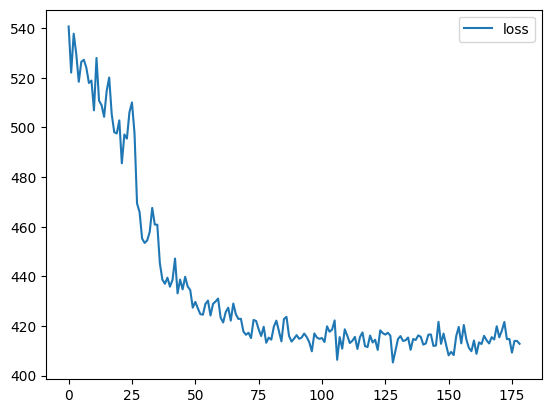

In [111]:
plt.plot(model_history.history['loss'][25:])
# plt.plot(model_history.history['rmse'])
# plt.plot(model_history.history['acc'])
# plt.plot(model_history.history['val_loss'])
# plt.plot(model_history.history['val_rmse'])
# plt.plot(model_history.history['val_acc'])
# plt.plot(model_history.history['lr'])

plt.legend(['loss','rmse','acc','val_loss','val_rmse','val_acc','lr'])

In [64]:
test_labels,test_images = utils.get_test_data(size=200)
test_labels = test_labels[:,:,:2].reshape(len(test_labels),-1)

In [65]:
model.evaluate(test_images,test_labels)

7/7 [==============================] - 1s 135ms/step - loss: 1569.0488 - rmse: 39.6112 - acc: 0.0600


[1569.048828125, 39.61122131347656, 0.05999999865889549]